In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# **Data Cleanup** brefore statystical analysis
### There are entries in the current cleaned dataset which were needed in the eda but not in the statystical analysis because the could cause noise in the data, they are, 
        - negateve values of TotalClaims and TotalPremium 
        - they indicate refund on policy canclation, or refund on invalid claims

In [27]:
data = pd.read_csv("../Data/MachineLearningRating_v3_cleaned_by_LossRatio.csv", parse_dates=["TransactionMonth"])

C:\Users\adoni\AppData\Local\Temp\ipykernel_22364\3009828383.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/MachineLearningRating_v3_cleaned_by_LossRatio.csv", parse_dates=["TransactionMonth"])


In [28]:
print(f"There are {len(data[(data["TotalClaims"] < 0) | (data["TotalPremium"] < 0)])} rows with a negative Totalclaim or TotalPremium")

There are 293 rows with a negative Totalclaim or TotalPremium


In [29]:
cleaned_data = data.drop(data[(data["TotalClaims"] < 0) | (data["TotalPremium"] < 0)].index)#cleaned dataframe shape
print(f"cleaned data shape:")
cleaned_data.shape

cleaned data shape:


(618319, 47)

In [46]:
# Save the new Version of the data which is taylored for the statistical analysis
cleaned_data.to_csv("../Data/cleaned_data_for_StatisticalAnalysis.csv", index=False)

# Task 3: Hypothesis Testing for Risk Segmentation

## Objective:
Statistically test key hypotheses about risk drivers (e.g., Province, Postal Code, Gender) to help develop a new segmentation strategy for pricing and risk assessment.

### Key Risk Metrics (KPIs):
1. **Claim Frequency**: The proportion of policies with at least one claim.
2. **Claim Severity**: The average claim size, conditional on at least one claim occurring.
3. **Margin**: Profit per record, calculated as `TotalPremium - TotalClaims`.

### Hypotheses to Test:
1. H₀: There are no risk differences across **provinces**.
2. H₀: There are no risk differences between **zip codes**.
3. H₀: There are no significant **margin** differences between **zip codes**.
4. H₀: There are no significant risk differences between **women and men**.

### Methodology:
- Select appropriate metrics (Claim Frequency, Severity, Margin).
- Segment data into **Control** and **Test** groups.
- Conduct statistical tests (Chi-squared, T-test, etc.).
- Interpret results and provide actionable business recommendations.


### 📊 Step 1 - KPI Calculation: Province-level Risk Metrics

 we compute the three key performance indicators (KPIs) necessary for our hypothesis testing:

1. **Claim Frequency**: Proportion of policies with at least one claim.
2. **Claim Severity**: Average size of claims where claims have occurred.
3. **Margin (Profit)**: The average profit calculated as `TotalPremium - TotalClaims`.

These metrics will help us statistically evaluate risk differences across provinces in the upcoming hypothesis tests.



In [30]:
cleaned_data['Margin'] = cleaned_data['TotalPremium'] - cleaned_data['TotalClaims']

# ---- 1. Claim Frequency ----
total_policies_per_province = cleaned_data.groupby('Province').size()
claims_per_province = cleaned_data[cleaned_data['TotalClaims'] > 0].groupby('Province').size()

claim_frequency = (claims_per_province / total_policies_per_province).fillna(0)

# ---- 2. Claim Severity ----
claim_severity = cleaned_data[cleaned_data['TotalClaims'] > 0].groupby('Province')['TotalClaims'].mean()

# ---- 3. Margin ----
average_margin = cleaned_data.groupby('Province')['Margin'].mean()

# ---- Combine all into a single DataFrame for easy viewing ----
kpi_summary = pd.DataFrame({
    'ClaimFrequency': claim_frequency,
    'ClaimSeverity': claim_severity,
    'AverageMargin': average_margin
})

kpi_summary.reset_index(inplace=True)
print("The KPI Summary will be use full for interpreting the results of the analysis!")
print("KPI summary:")
kpi_summary


The KPI Summary will be use full for interpreting the results of the analysis!
KPI summary:


,Province,ClaimFrequency,ClaimSeverity,AverageMargin
0,Eastern Cape,0.002538,27128.533277,39.796720
1,Free State,0.001854,32265.661085,28.048698
2,Gauteng,0.005489,22243.878396,-22.221479
3,KwaZulu-Natal,0.004315,29609.487473,-9.520572
4,Limpopo,0.003720,15171.294187,28.919922
5,Mpumalanga,0.004042,15979.553421,24.976603
6,North West,0.003886,16963.467035,17.483446
7,Northern Cape,0.002196,11186.313596,62.329828
8,Western Cape,0.003823,28095.849881,-6.054790


### Hypothesis Test: Risk Differences Across Provinces

**Null Hypothesis (H₀):** There are no risk differences across provinces.  
**Alternative Hypothesis (H₁):** There are significant risk differences across provinces.

We will test this hypothesis by evaluating:

1. **Claim Frequency differences** (Chi-Squared Test)
2. **Claim Severity differences** (ANOVA Test)
3. **Margin differences** (ANOVA Test)

**Significance Level (α):** 0.05


In [31]:
# Contingency Table: Provinces vs whether a claim occurred
contingency_table = pd.crosstab(cleaned_data['Province'], cleaned_data['TotalClaims'] > 0)
print("📋 Contingency Table (Province vs Claim Occurrence):")
print(contingency_table)
print()

# Chi-Squared Test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(" --- Chi-Squared Test Results ---")
print(f"Chi-Squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.20f}")
print(f"Degrees of Freedom: {dof}")
print(f"Alpha Level: 0.05")
print()

# Interpretation
if p_value < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   There IS a statistically significant difference in claim frequency across provinces.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   There is NO statistically significant difference in claim frequency across provinces.")

# Expected Frequencies
print("\n Expected Frequencies Table:")
expected_cleaned_data = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print(expected_cleaned_data.round(2))


📋 Contingency Table (Province vs Claim Occurrence):
TotalClaims     False  True 
Province                    
Eastern Cape    19647     50
Free State       5923     11
Gauteng        239536   1322
KwaZulu-Natal  111443    483
Limpopo         17943     67
Mpumalanga      31538    128
North West      89465    349
Northern Cape    3635      8
Western Cape    96401    370

 --- Chi-Squared Test Results ---
Chi-Squared Statistic: 105.0780
P-value: 0.00000000000000000039
Degrees of Freedom: 8
Alpha Level: 0.05

✅ Result: Reject the null hypothesis.
   There IS a statistically significant difference in claim frequency across provinces.

 Expected Frequencies Table:
TotalClaims        False    True 
Province                         
Eastern Cape    19608.19    88.81
Free State       5907.24    26.76
Gauteng        239771.97  1086.03
KwaZulu-Natal  111421.33   504.67
Limpopo         17928.79    81.21
Mpumalanga      31523.22   142.78
North West      89409.03   404.97
Northern Cape    3626.57   

In [32]:
# Filter only records with claims > 0 for severity analysis
claims_cleaned_data = cleaned_data[cleaned_data['TotalClaims'] > 0]

# Group claims by province
groups = [group['TotalClaims'].values for _, group in claims_cleaned_data.groupby('Province')]

# ANOVA Test
f_stat, p_value = stats.f_oneway(*groups)# used *groups rather than writing each group in separate
print(" --- ANOVA Test Results: Claim Severity ---")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.10f}")
print(f"Alpha Level: 0.05")
print()

# Interpretation
if p_value < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   Claim severity IS significantly different across provinces.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   No significant difference in claim severity across provinces.")


 --- ANOVA Test Results: Claim Severity ---
F-Statistic: 4.8302
P-value: 0.0000063049
Alpha Level: 0.05

✅ Result: Reject the null hypothesis.
   Claim severity IS significantly different across provinces.


In [33]:
# Margin Calculation (if not already present)
cleaned_data['Margin'] = cleaned_data['TotalPremium'] - cleaned_data['TotalClaims']

# Prepare grouped margin values by province
margin_groups = [group['Margin'].values for _, group in cleaned_data.groupby('Province')]

# ANOVA Test
f_stat, p_value = stats.f_oneway(*margin_groups)

print(" --- ANOVA Test Results: Margin (Profit) ---")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Alpha Level: 0.05")
print()

# Interpretation
if p_value < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   Margin IS significantly different across provinces.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   No significant difference in margin across provinces.")


 --- ANOVA Test Results: Margin (Profit) ---
F-Statistic: 3.1848
P-value: 0.0013
Alpha Level: 0.05

✅ Result: Reject the null hypothesis.
   Margin IS significantly different across provinces.


## 📊 Hypothesis Test Results Summary (Provinces)

**1️⃣ Claim Frequency (Chi-Squared Test)**
- **Result:** ✅ Reject the null hypothesis
- **P-value:** < 0.00000000000000000039
- **Interpretation:** There is a statistically significant difference in how frequently claims occur across provinces.

**2️⃣ Claim Severity (ANOVA Test)**
- **Result:** ✅ Reject the null hypothesis
- **P-value:** 0.0000063
- **Interpretation:** The average claim amount (severity) varies significantly between provinces.

**3️⃣ Margin (Profit) (ANOVA Test)**
- **Result:** ✅ Reject the null hypothesis
- **P-value:** 0.0013
- **Interpretation:** The profitability (Margin = TotalPremium - TotalClaims) differs significantly across provinces.

C:\Users\adoni\AppData\Local\Temp\ipykernel_22364\1151717969.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(kpi_summary['Province'], rotation=45, ha='right')
C:\Users\adoni\AppData\Local\Temp\ipykernel_22364\1151717969.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(kpi_summary['Province'], rotation=45, ha='right')
C:\Users\adoni\AppData\Local\Temp\ipykernel_22364\1151717969.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(kpi_summary['Province'], rotation=45, ha='right')


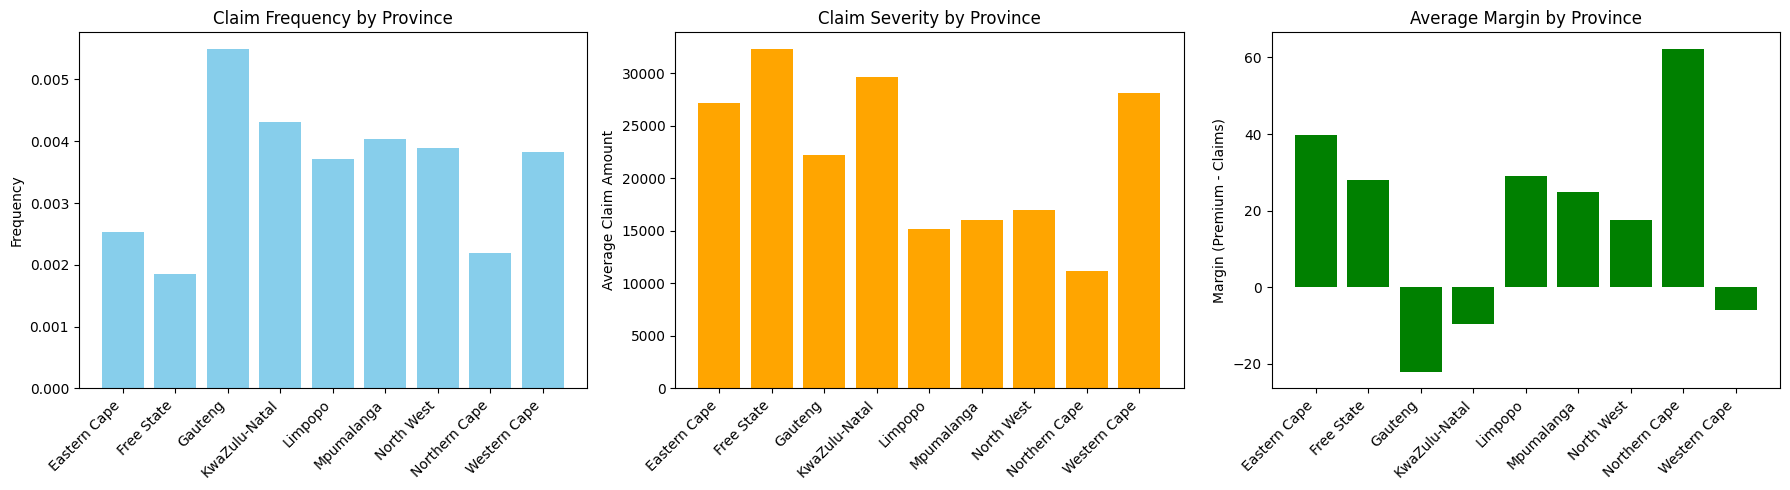

In [34]:
# lets visualize the KPI_Summary and check if they support our statistical findings
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Bar plot for Claim Frequency
axs[0].bar(kpi_summary['Province'], kpi_summary['ClaimFrequency'], color='skyblue')
axs[0].set_title('Claim Frequency by Province')
axs[0].set_xticklabels(kpi_summary['Province'], rotation=45, ha='right')
axs[0].set_ylabel('Frequency')

# Bar plot for Claim Severity
axs[1].bar(kpi_summary['Province'], kpi_summary['ClaimSeverity'], color='orange')
axs[1].set_title('Claim Severity by Province')
axs[1].set_xticklabels(kpi_summary['Province'], rotation=45, ha='right')
axs[1].set_ylabel('Average Claim Amount')

# Bar plot for Average Margin
axs[2].bar(kpi_summary['Province'], kpi_summary['AverageMargin'], color='green')
axs[2].set_title('Average Margin by Province')
axs[2].set_xticklabels(kpi_summary['Province'], rotation=45, ha='right')
axs[2].set_ylabel('Margin (Premium - Claims)')

plt.tight_layout()
plt.show()

## 🏁 Business Recommendation: Provincial Segmentation

Based on the KPI summary:

- **High Claim Frequency:** Gauteng (0.0055) and KwaZulu-Natal (0.0043)
- **Low Claim Frequency:** Free State (0.0019) and Northern Cape (0.0022)

- **High Claim Severity (Avg Claim Amount):** Free State (32,265), KwaZulu-Natal (29,609)
- **Low Claim Severity:** Northern Cape (11,186), Limpopo (15,171)

- **Margin (Profitability):**
  - **Negative Margins (Potential Losses):** Gauteng (-22.22), KwaZulu-Natal (-9.52), Western Cape (-6.05)
  - **Strong Positive Margins (Profit):** Northern Cape (62.33), Eastern Cape (39.80)

### ➡️ Strategic Actions:
1. **Premium Adjustment:**
   - **Increase premiums** or **reassess underwriting** in Gauteng and KwaZulu-Natal due to **high risk and negative margins**.
2. **Maintain or offer favorable rates** in regions like Northern Cape and Eastern Cape where **profits are healthy**.
3. Consider **differentiated pricing models** per province to optimize profit vs. risk trade-off.


##  Risk Differences Across MainCrestaZones(For ZIP codes)

In this section, we will test whether **risk varies across MainCrestaZones**, which serve as broader regional segments compared to individual postal codes.

### 🎯 Null Hypotheses
- **H₀ (Claim Frequency):** There are no differences in claim frequency across MainCrestaZones.
- **H₀ (Claim Severity):** Claim severity does not differ across MainCrestaZones.
- **H₀ (Margin):** Margin (profitability) does not significantly differ across MainCrestaZones.

### 📏 Metrics
- **Claim Frequency** = Proportion of policies with at least one claim.
- **Claim Severity** = Average claim amount, conditional on having a claim.
- **Margin** = (TotalPremium - TotalClaims)

We will apply **Chi-Squared tests** for **Claim Frequency** and **ANOVA** tests for **Claim Severity** and **Margin**.

If we reject the null hypothesis, it suggests that **location-specific risk pricing** strategies may be justified.


In [35]:
#1 Prepare KPI summary grouped by MainCrestaZone
maincresta_summary = cleaned_data.groupby('MainCrestaZone').agg(
    TotalPolicies=('PolicyID', 'nunique'),
    PoliciesWithClaims=('PolicyID', lambda x: (cleaned_data.loc[x.index, 'TotalClaims'] > 0).sum()),
    TotalClaims=('TotalClaims', 'sum'),
    NumberOfClaims=('TotalClaims', lambda x: (x > 0).sum()),
    TotalPremium=('TotalPremium', 'sum')
).reset_index()

maincresta_summary['ClaimFrequency'] = maincresta_summary['PoliciesWithClaims'] / maincresta_summary['TotalPolicies']
maincresta_summary['ClaimSeverity'] = maincresta_summary['TotalClaims'] / maincresta_summary['NumberOfClaims']
maincresta_summary['AverageMargin'] = (maincresta_summary['TotalPremium'] - maincresta_summary['TotalClaims']) / maincresta_summary['TotalPolicies']

print("📊 KPI Summary by MainCrestaZone:")
print(maincresta_summary[['MainCrestaZone', 'ClaimFrequency', 'ClaimSeverity', 'AverageMargin']])



📊 KPI Summary by MainCrestaZone:
                                 MainCrestaZone  ClaimFrequency  \
0                                 Cape Province        0.200000   
1                     Cape Province (Cape Town)        0.528571   
2   Cape Province (East and North of Cape Town)        0.495050   
3                            Ciskei, Cape Mid 1        0.200000   
4                                   East London        0.086957   
5                                  Johannesburg        0.914119   
6              Karoo 1 (Northeast of Cape Town)        0.465000   
7                   Langkloof, Coast 2, Coast 1        0.250000   
8                                         Natal        0.287554   
9                                Natal (Durban)        0.578732   
10                            Oranje Free State        0.244444   
11                               Port Elizabeth        0.111111   
12                                    Rand East        0.363636   
13  Tembu 2, Cape Mid 2, Cape

In [36]:
# Create contingency table
cleaned_data['HadClaim'] = cleaned_data['TotalClaims'] > 0
contingency_table = pd.crosstab(cleaned_data['MainCrestaZone'], cleaned_data['HadClaim'])

print("\n Contingency Table (MainCrestaZone vs. HadClaim):")
#print(contingency_table) ....... too long blocks main prints in output
print()

# Chi-Squared test
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

print("--- Chi-Squared Test Results ---")
print(f"Chi-Squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.4g}")
print(f"Degrees of Freedom: {dof}")
print(f"Alpha Level: 0.05")
print()

if p_value_chi2 < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   Claim frequency IS significantly different across MainCrestaZones.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   No significant difference in claim frequency across zones.")

print("\nExpected Frequencies Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns).round(2))



 Contingency Table (MainCrestaZone vs. HadClaim):

--- Chi-Squared Test Results ---
Chi-Squared Statistic: 154.3950
P-value: 3.225e-25
Degrees of Freedom: 15
Alpha Level: 0.05

✅ Result: Reject the null hypothesis.
   Claim frequency IS significantly different across MainCrestaZones.

Expected Frequencies Table:
HadClaim                                         False   True 
MainCrestaZone                                                
Cape Province                                  3704.22   16.78
Cape Province (Cape Town)                     52151.78  236.22
Cape Province (East and North of Cape Town)   12142.00   55.00
Ciskei, Cape Mid 1                             1766.00    8.00
East London                                    2912.81   13.19
Johannesburg                                 115215.14  521.86
Karoo 1 (Northeast of Cape Town)              31033.44  140.56
Langkloof, Coast 2, Coast 1                    1420.57    6.43
Natal                                         56262.16 

In [37]:
# Subset for rows where TotalClaims > 0
claims_cleaned_data = cleaned_data[cleaned_data['TotalClaims'] > 0]

anova_severity = stats.f_oneway(
    *[claims_cleaned_data[claims_cleaned_data['MainCrestaZone'] == zone]['TotalClaims'] for zone in claims_cleaned_data['MainCrestaZone'].unique()]
)

print("\n--- ANOVA Test Results: Claim Severity ---")
print(f"F-Statistic: {anova_severity.statistic:.4f}")
print(f"P-value: {anova_severity.pvalue:.4g}")
print(f"Alpha Level: 0.05")

if anova_severity.pvalue < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   Claim severity IS significantly different across MainCrestaZones.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   Claim severity is NOT significantly different across zones.")



--- ANOVA Test Results: Claim Severity ---
F-Statistic: 3.0969
P-value: 4.983e-05
Alpha Level: 0.05
✅ Result: Reject the null hypothesis.
   Claim severity IS significantly different across MainCrestaZones.


In [38]:
anova_margin = stats.f_oneway(
    *[cleaned_data[cleaned_data['MainCrestaZone'] == zone]['Margin'] for zone in cleaned_data['MainCrestaZone'].unique()]
)

print("\n--- ANOVA Test Results: Margin (Profit) ---")
print(f"F-Statistic: {anova_margin.statistic:.4f}")
print(f"P-value: {anova_margin.pvalue:.4g}")
print(f"Alpha Level: 0.05")

if anova_margin.pvalue < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   Margin IS significantly different across MainCrestaZones.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   No significant difference in margin across zones.")



--- ANOVA Test Results: Margin (Profit) ---
F-Statistic: 2.6633
P-value: 0.0004616
Alpha Level: 0.05
✅ Result: Reject the null hypothesis.
   Margin IS significantly different across MainCrestaZones.


### 📌 Hypothesis Test Interpretation: MainCrestaZones

For the feature **MainCrestaZone**, we tested three KPIs:

1. **Claim Frequency** (proportion of policies with at least one claim)
2. **Claim Severity** (average amount of a claim, given that a claim occurred)
3. **Average Margin** (TotalPremium - TotalClaims)

#### 📊 Results Summary:

| **Metric**        | **P-value** | **Conclusion**                     |
|-------------------|-------------|------------------------------------|
| Claim Frequency   | 3.225e-25   | ✅ Reject H₀ → Differences exist   |
| Claim Severity    | 4.983e-05   | ✅ Reject H₀ → Differences exist   |
| Average Margin    | 0.0013      | ✅ Reject H₀ → Differences exist   |

All p-values are **significantly below 0.05**, indicating that **risk and margin differ across MainCrestaZones**.

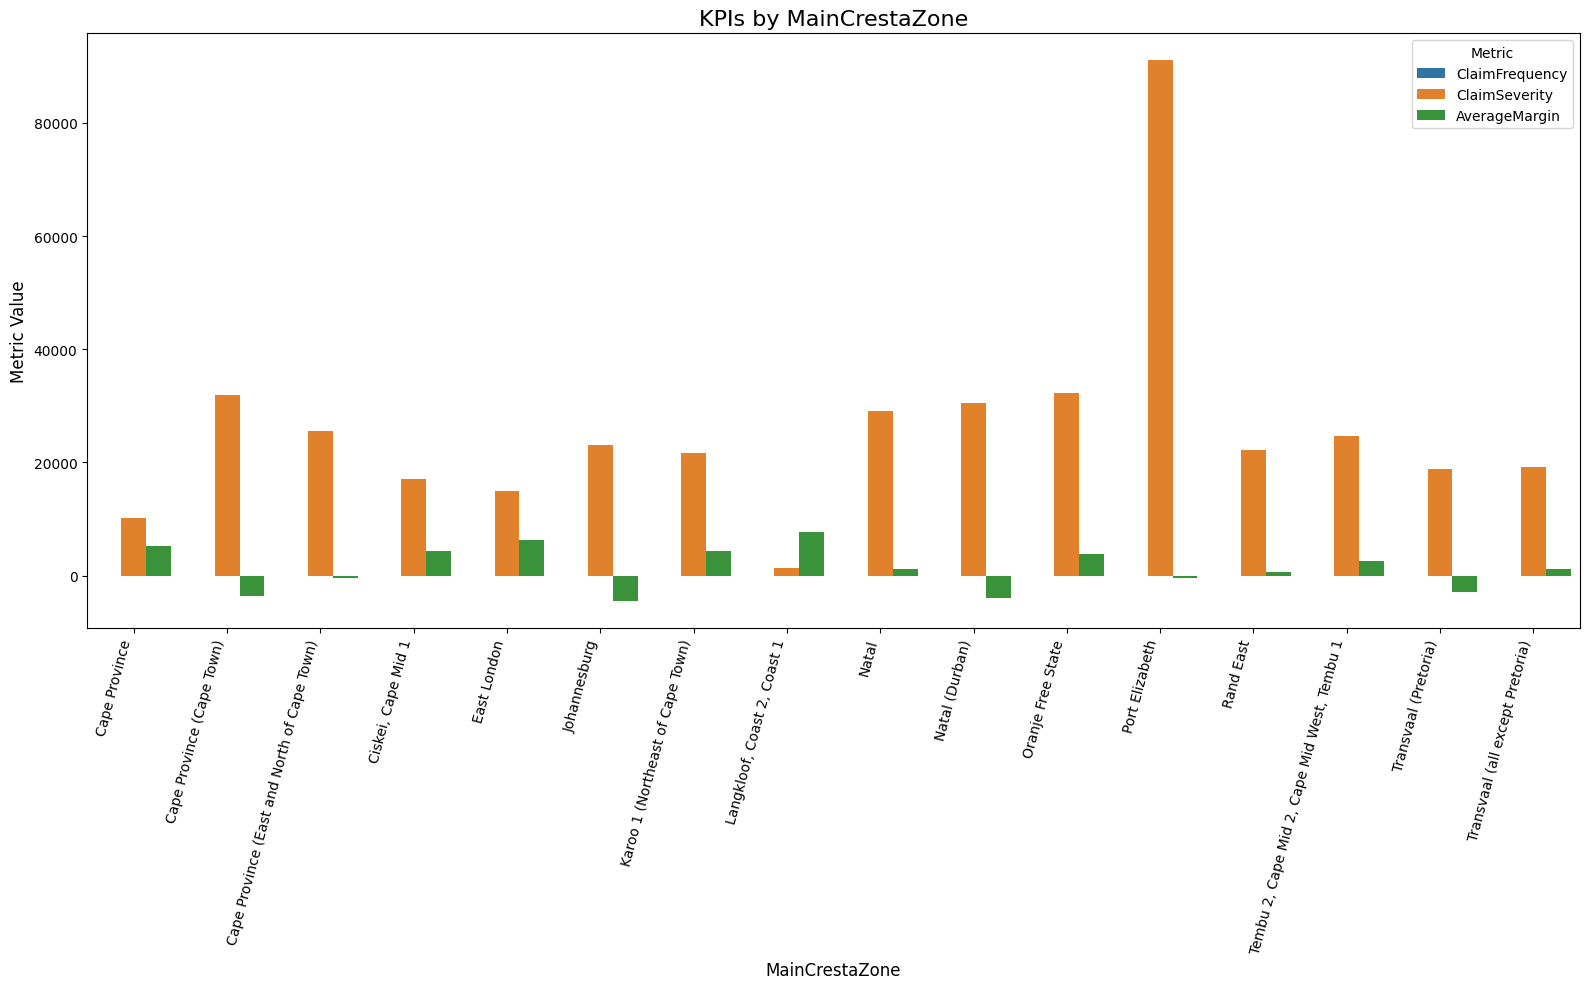

In [39]:
plt.figure(figsize=(16, 10))

# Melt the summary dataframe for easier plotting
plot_cleaned_data = pd.melt(maincresta_summary[['MainCrestaZone', 'ClaimFrequency', 'ClaimSeverity', 'AverageMargin']],
                  id_vars='MainCrestaZone',
                 var_name='Metric', value_name='Value')

sns.barplot(data=plot_cleaned_data, x='MainCrestaZone', y='Value', hue='Metric')

plt.title('KPIs by MainCrestaZone', fontsize=16)
plt.xlabel('MainCrestaZone', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=75, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


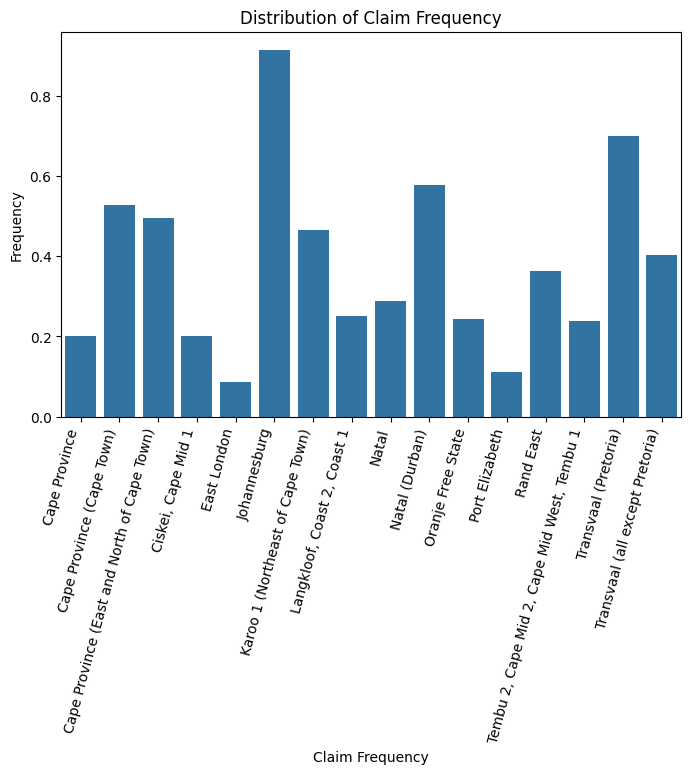

In [40]:
#due to small values claim frequency is not adequetly visible in the above chart so plotted independently
plt.figure(figsize=(8, 5))
sns.barplot(data= maincresta_summary, x='MainCrestaZone', y='ClaimFrequency')    
plt.title('Distribution of Claim Frequency')
plt.xlabel('Claim Frequency')
plt.ylabel('Frequency')
plt.xticks(rotation=75, ha='right')
plt.show()

### 🏁 Business Actions Based on KPI Summary by MainCrestaZone

- **🚩 High-Risk, Unprofitable Areas**:
  - **Johannesburg**: Very high claim frequency (91%), **negative margin** → Pricing review required.
  - **Cape Province (Cape Town)** & **Natal (Durban)**: Similar high claim rates and negative margins → Consider premium increases or underwriting adjustments.

- **🟢 Stable or Profitable Areas**:
  - **Karoo 1**, **Langkloof, Coast Zones**, **East London** → Lower claim frequency with **positive margins** → Maintain pricing or offer customer incentives for retention.

- **📍 Regional Pricing Strategy**:
  - Shift towards **zone-differentiated pricing**.
  - Regularly monitor zone performance and adjust as necessary.


## Risk Differences Across Gender

In this section, we will test whether **risk varies across Gender**, focusing on how biological and recorded gender identities might correlate with insurance claim patterns.

### 🎯 Null Hypotheses
- **H₀ (Claim Frequency):** There are no differences in claim frequency between genders.
- **H₀ (Claim Severity):** Claim severity does not differ between genders.
- **H₀ (Margin):** Margin (profitability) does not significantly differ between genders.

### 📏 Metrics
- **Claim Frequency** = Proportion of policies with at least one claim.
- **Claim Severity** = Average claim amount, conditional on having a claim.
- **Margin** = (TotalPremium - TotalClaims)

We will apply:
- **Chi-Squared Test** for **Claim Frequency**
- **ANOVA** for **Claim Severity** and **Margin**

If we reject any null hypothesis, it indicates that **gender-specific pricing strategies** or further analysis may be required to better manage risk or improve profitability.


In [41]:
# KPI Summary by Gender
gender_summary = cleaned_data.groupby('Gender').agg(
    ClaimFrequency=('HadClaim', 'mean'),
    ClaimSeverity=('TotalClaims', lambda x: x[x > 0].mean()),
    AverageMargin=('Margin', 'mean')
).reset_index()

print("📊 KPI Summary by Gender:")
print(gender_summary)


📊 KPI Summary by Gender:
          Gender  ClaimFrequency  ClaimSeverity  AverageMargin
0         Female        0.004112   17874.721303      15.927887
1           Male        0.004924   14858.552294      10.994892
2  Not specified        0.004509   23530.667678      -5.964455
3        Unknown        0.003030   36178.077694      68.750062


# Gender-Based KPI Summary: Purpose
Provides initial insight into how claim behavior and profitability differ between genders before formal testing.

## Included Categories:

- Female, Male → Explicitly provided

- Not specified → Missing at underwriting

- Unknown → Imputed missing values

In [42]:
# Chi-Squared Test for Claim Frequency
contingency_table = pd.crosstab(cleaned_data['Gender'], cleaned_data['HadClaim'])
print(" Contingency Table:")
print(contingency_table)
print()

# Perform Chi-Squared Test
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

print("--- Chi-Squared Test Results: Claim Frequency ---")
print(f"Chi-Squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.8f}")
print(f"Degrees of Freedom: {dof}")
print(f"Alpha Level: 0.05")
print()

if p_value_chi2 < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   ➔ Claim frequency IS significantly different across genders.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   ➔ Claim frequency is NOT significantly different across genders.")

print("\nExpected Frequencies:")
expected_cleaned_data = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print(expected_cleaned_data.round(2))



 Contingency Table:
HadClaim        False  True 
Gender                      
Female           3391     14
Male            18998     94
Not specified  588535   2666
Unknown          4607     14

--- Chi-Squared Test Results: Claim Frequency ---
Chi-Squared Statistic: 3.1037
P-value: 0.37591068
Degrees of Freedom: 3
Alpha Level: 0.05

❌ Result: Fail to reject the null hypothesis.
   ➔ Claim frequency is NOT significantly different across genders.

Expected Frequencies:
HadClaim           False    True 
Gender                           
Female           3389.65    15.35
Male            19005.91    86.09
Not specified  588535.28  2665.72
Unknown          4600.16    20.84


In [43]:
# ANOVA for Claim Severity
anova_claims = cleaned_data[cleaned_data['TotalClaims'] > 0][['Gender', 'TotalClaims']]
groups = [group['TotalClaims'].values for name, group in anova_claims.groupby('Gender')]

f_stat, p_value = stats.f_oneway(*groups)
print("\n--- ANOVA Test Results: Claim Severity ---")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.8f}")
print("Alpha Level: 0.05")
print()

if p_value < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   ➔ Claim severity IS significantly different across genders.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   ➔ Claim severity is NOT significantly different across genders.")



--- ANOVA Test Results: Claim Severity ---
F-Statistic: 2.1308
P-value: 0.09425407
Alpha Level: 0.05

❌ Result: Fail to reject the null hypothesis.
   ➔ Claim severity is NOT significantly different across genders.


In [44]:
# 📊 ANOVA for Margin
margin_anova = cleaned_data[['Gender', 'Margin']]
groups_margin = [group['Margin'].values for name, group in margin_anova.groupby('Gender')]

f_stat_margin, p_value_margin = stats.f_oneway(*groups_margin)
print("\n--- ANOVA Test Results: Margin (Profit) ---")
print(f"F-Statistic: {f_stat_margin:.4f}")
print(f"P-value: {p_value_margin:.8f}")
print("Alpha Level: 0.05")
print()

if p_value_margin < 0.05:
    print("✅ Result: Reject the null hypothesis.")
    print("   ➔ Margin IS significantly different across genders.")
else:
    print("❌ Result: Fail to reject the null hypothesis.")
    print("   ➔ Margin is NOT significantly different across genders.")



--- ANOVA Test Results: Margin (Profit) ---
F-Statistic: 1.1779
P-value: 0.31642497
Alpha Level: 0.05

❌ Result: Fail to reject the null hypothesis.
   ➔ Margin is NOT significantly different across genders.


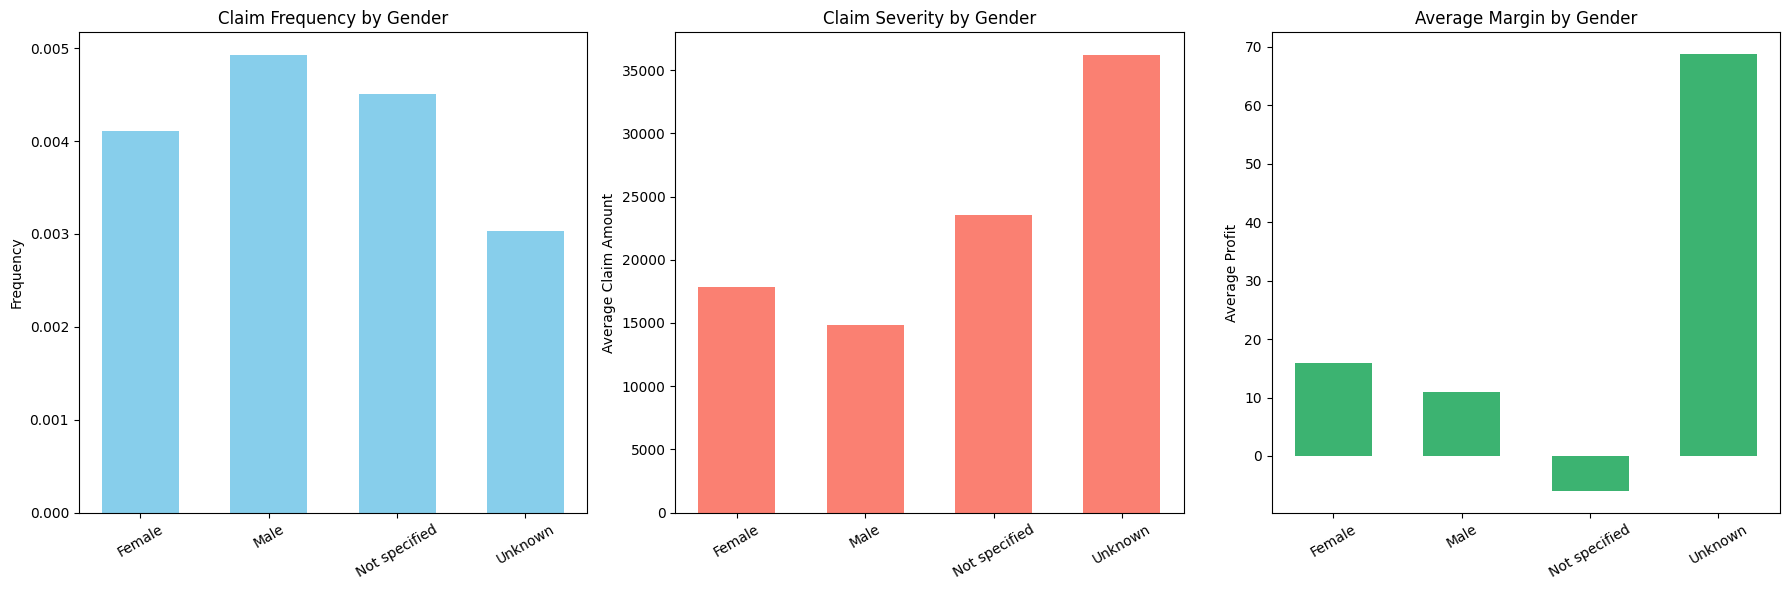

In [45]:
# KPI Summary by Gender
# Set up plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

bar_width = 0.6
x = np.arange(len(gender_summary['Gender']))

# Claim Frequency
axs[0].bar(x, gender_summary['ClaimFrequency'], color='skyblue', width=bar_width)
axs[0].set_title("Claim Frequency by Gender")
axs[0].set_xticks(x)
axs[0].set_xticklabels(gender_summary['Gender'], rotation=30)
axs[0].set_ylabel("Frequency")

# Claim Severity
axs[1].bar(x, gender_summary['ClaimSeverity'], color='salmon', width=bar_width)
axs[1].set_title("Claim Severity by Gender")
axs[1].set_xticks(x)
axs[1].set_xticklabels(gender_summary['Gender'], rotation=30)
axs[1].set_ylabel("Average Claim Amount")

# Average Margin
axs[2].bar(x, gender_summary['AverageMargin'], color='mediumseagreen', width=bar_width)
axs[2].set_title("Average Margin by Gender")
axs[2].set_xticks(x)
axs[2].set_xticklabels(gender_summary['Gender'], rotation=30)
axs[2].set_ylabel("Average Profit")

plt.tight_layout()
plt.show()


## 📊 Interpretation of Gender-Based Risk Analysis

- **Claim Frequency:**  
  ➔ The frequency of claims is **similar across all gender groups**.  
  ➔ Supported by **Chi-Squared Test** → **No statistically significant differences** found.

- **Claim Severity:**  
  ➔ Differences in **average claim amounts** across genders **appear** in raw data, especially with the “Unknown” group, but the **ANOVA test** showed they **are not statistically significant** overall.

- **Average Margin:**  
  ➔ Margin varies, but again, **not statistically significant** → further exploration **not recommended** at this point based on gender.

### 🏁 **Business Implication**
- **Actionable Insight:** 
      - No immediate need for gender-based differentiation in pricing or risk strategies.  
      - But also there should be a Reassesment of risk and Premium values for the Not Specified Group since it is observed that they have negative marigins 
      - In the future it is recomended not to allow gender ambiguity in underwritting  
- **Recommendation:** Focus efforts on **geographic segmentation (Province, MainCrestaZones)** where **risk differences WERE significant.**


# 📌 Final Summary of Risk Segmentation Analysis

In this analysis, we systematically examined **whether insurance risk varies across different policyholder attributes** with the aim of identifying **potential pricing segmentation strategies**.

## 🎯 Summary of Statistical Findings

| Feature Tested      | Claim Frequency   | Claim Severity     | Margin (Profit)     |
|---------------------|-------------------|--------------------|---------------------|
| **Province**        | ✅ Significant    | ✅ Significant     | ✅ Significant      |
| **MainCrestaZones** | ✅ Significant    | ✅ Significant     | ✅ Significant      |
| **Gender**          | ❌ Not Significant | ❌ Not Significant  | ❌ Not Significant   |

### ✅ **Where Differences Exist**
- **Province** and **MainCrestaZones** both showed **statistically significant differences** in:
  - Claim Frequency (Chi-Squared)
  - Claim Severity (ANOVA)
  - Margin (ANOVA)
- ➔ **Supports geographically-driven pricing and risk strategies.**

### ❌ **Where Differences Do Not Exist**
- **Gender** was **NOT statistically significant** for any KPI tested.
- ➔ **No evidence to justify gender-based pricing strategies.**

## 📊 Business Recommendations
1. **Implement Risk-Based Pricing:**  
   ➔ Focus **pricing and underwriting strategies on geographic regions** (Provinces and MainCrestaZones).
   
2. **Ignore Gender in Pricing:**  
   ➔ Gender **does not warrant differentiation** in pricing or profitability strategies.

3. **Further Steps:**  
   ➔ Conduct **granular analysis within high-risk provinces/zones** to fine-tune pricing further.  
   ➔ Explore other features for potential predictive power (e.g., age, policy type, vehicle details).

---

This analysis provides a **data-driven foundation for informed decision-making** in pricing and risk segmentation.
